<a href="https://www.kaggle.com/code/yersel/bone-fracture-classification?scriptVersionId=175147421" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [23]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import random
from PIL import Image

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

def list_png_files(root_dir):
    png_files = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith('.png'):
                full_path = os.path.join(subdir, file)
                png_files.append(full_path)
    return png_files

train_dir = '../input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train'
val_dir = '../input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val'
test_dir = '../input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'

train_png_files = list_png_files(train_dir)
val_png_files = list_png_files(val_dir)
test_png_files = list_png_files(test_dir)

In [24]:
def parse_image(filename):
    parts = tf.strings.split(filename, os.sep)
    label = parts[-2] == 'fractured'  # Example for binary labels based on folder names
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0
    return image, tf.cast(label, tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices(train_png_files)
train_dataset = train_dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_png_files)
val_dataset = val_dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_png_files)
test_dataset = test_dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

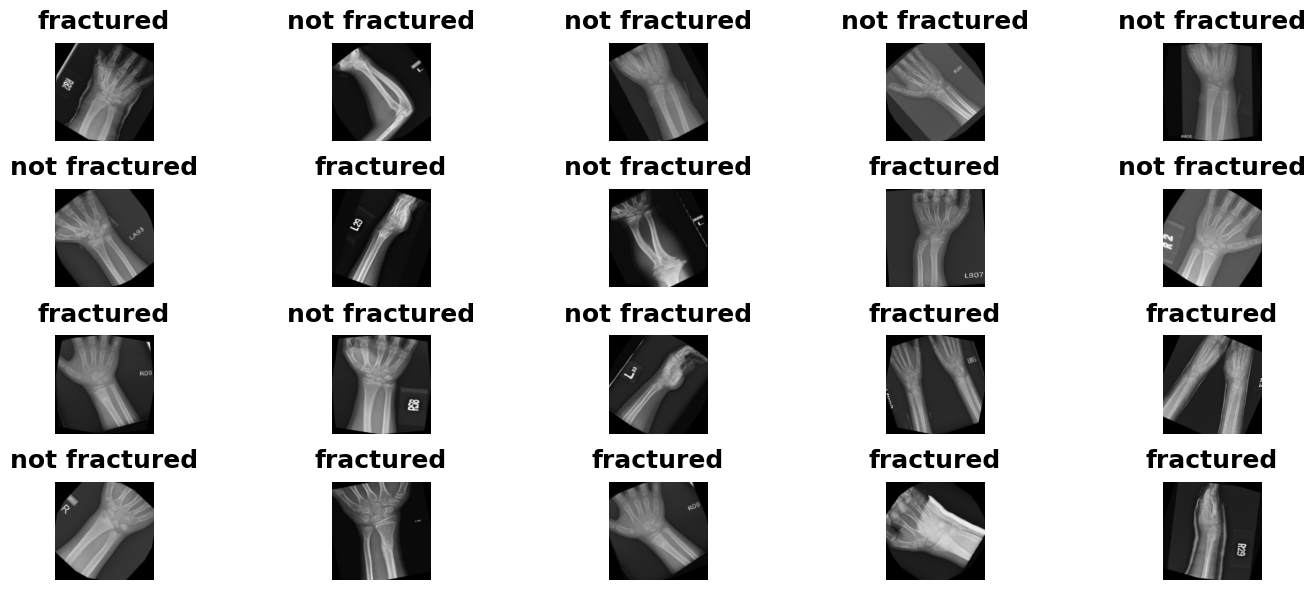

In [25]:
def display_random_images(path, num_images=20):
    subfolders = ['fractured', 'not fractured']  # Subfolder names
    images_to_display = []

    # Collect images from each subfolder
    for folder in subfolders:
        full_path = os.path.join(path, folder)
        images = [os.path.join(full_path, img) for img in os.listdir(full_path)]
        images_to_display.extend(random.sample(images, num_images // len(subfolders)))  # Even sampling from each subfolder

    # Shuffle the final list of images to display
    random.shuffle(images_to_display)

    # Create subplots
    fig, axes = plt.subplots(nrows=num_images // 5, ncols=5, figsize=(15, num_images // 3))
    axes = axes.flatten()

    # Display each image
    for img_path, ax in zip(images_to_display, axes):
        image = Image.open(img_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(img_path.split('/')[-2])  # Title as the category

    plt.tight_layout()
    plt.show()
    
# Show images com Train Dataset
display_random_images(train_dir)

**Show images from validation Dataset**

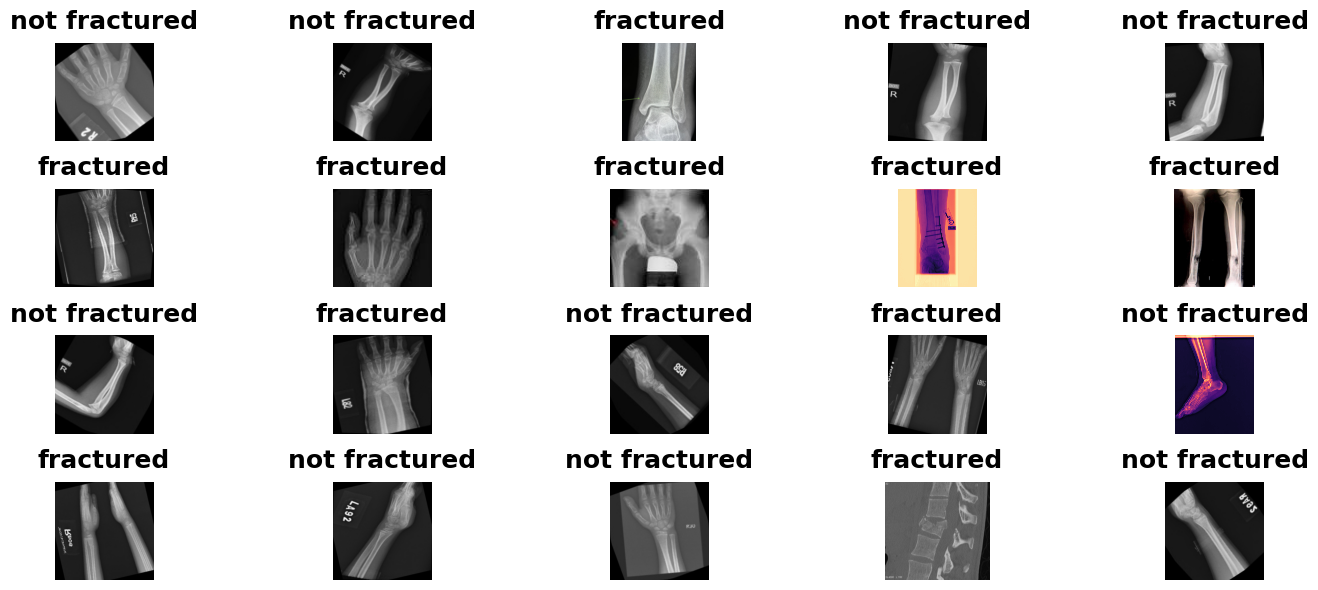

In [26]:
display_random_images(val_dir)

Show images from Test Dataset

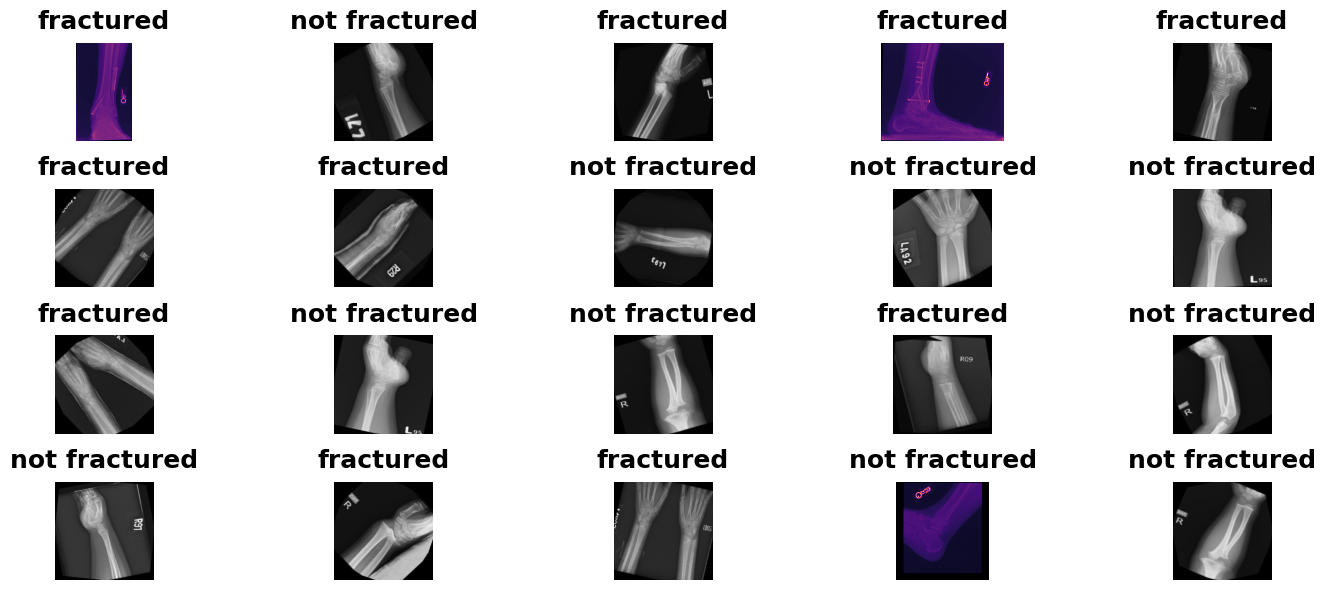

In [27]:
display_random_images(test_dir)

# Define Pretrained Base

In [28]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load the VGG16 model, pretrained on ImageNet data
pretrained_base = VGG16(weights='imagenet', include_top=False)

# Define and train the model

In [29]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


In [30]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss = 'binary_crossentropy',
    metrics=['binary_accuracy'],
)


In [31]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 9s/step - binary_accuracy: 0.3598 - loss: 0.7348 - val_binary_accuracy: 0.5593 - val_loss: 0.6925
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - binary_accuracy: 0.4799 - loss: 0.6984 - val_binary_accuracy: 0.6780 - val_loss: 0.6189
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 8s/step - binary_accuracy: 0.6313 - loss: 0.6434 - val_binary_accuracy: 0.6949 - val_loss: 0.5488
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - binary_accuracy: 0.6350 - loss: 0.5896 - val_binary_accuracy: 0.6949 - val_loss: 0.4835
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 9s/step - binary_accuracy: 0.6662 - loss: 0.5112 - val_binary_accuracy: 0.6949 - val_loss: 0.4758
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - binary_accuracy: 0.6387 - loss: 0.5044 - val_binary_accuracy: 0.6949 - val_loss: 0.4917
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - binary_accuracy: 0.6736 - loss: 0.4915 - val_binary_accuracy: 0.6949 - val_loss: 0.4144
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━

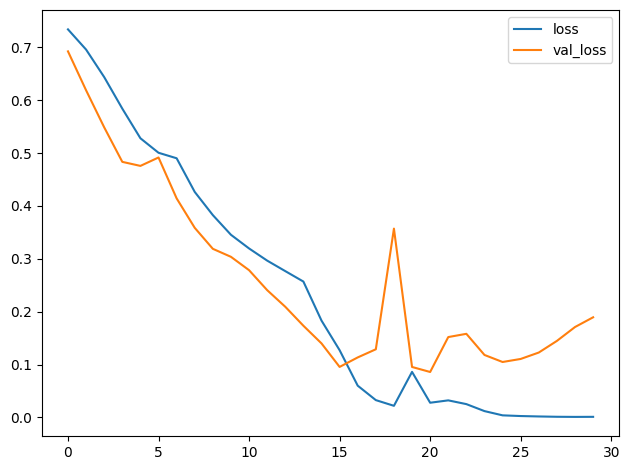

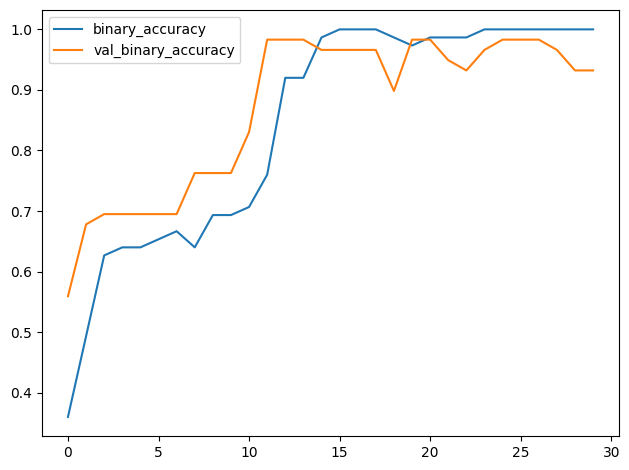

In [32]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

**Let's check the accuracy of our model with our test dataset:**

In [33]:
_, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - binary_accuracy: 0.9298 - loss: 0.4766
Test Accuracy: 0.9298245906829834


**We obtain an accuracy of 93%.**

# Display random images from the test dataset along with their predictions

In [45]:
def get_random_images_and_labels(dataset, num_samples=20):
    for image_batch, label_batch in dataset:
        # Flatten the batch to handle cases where batch size > num_samples
        images = image_batch.numpy()
        labels = label_batch.numpy()

        # Randomly select num_samples images and labels
        indices = np.random.choice(range(len(images)), num_samples, replace=False)
        selected_images = images[indices]
        selected_labels = labels[indices]
        
        return selected_images, selected_labels

# Fetch random images and labels
random_test_images, random_test_labels = get_random_images_and_labels(test_dataset)

# Predict on these images
predictions = model.predict(random_test_images)
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


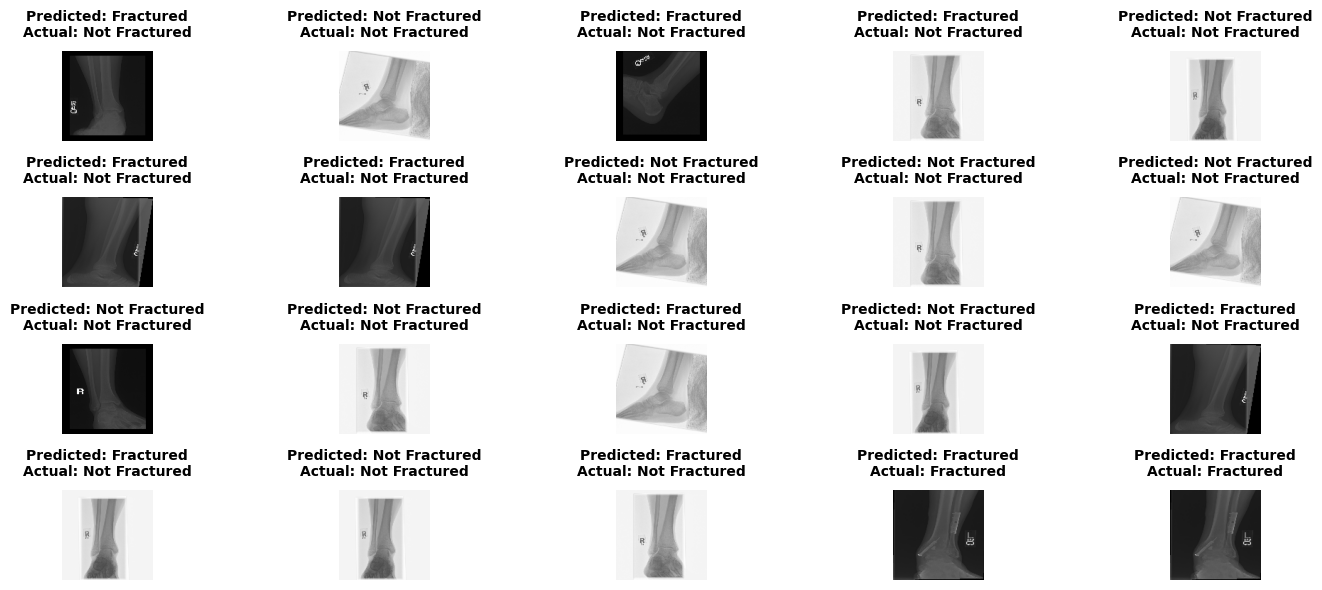

In [46]:
def plot_images_with_predictions(images, actual, predictions, num_images=20):
    fig, axes = plt.subplots(nrows=num_images // 5, ncols=5, figsize=(15, num_images // 3))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
        
        pred_label = 'Fractured' if predictions[i] == 1 else 'Not Fractured'
        actual_label = 'Fractured' if actual[i] == 1 else 'Not Fractured'
        title = f'Predicted: {pred_label}\nActual: {actual_label}'
        ax.set_title(title, fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Display images with predictions
plot_images_with_predictions(test_images, test_labels, predicted_classes)
